In [48]:
from generator import Generator
from critic import Critic
from dog_dataset import DogData

In [49]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch import optim

In [50]:
batchSize = 1

In [51]:
transform = transforms.Compose( [ transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) ] )
dogdata = DogData(transform)
dogloader = DataLoader(dogdata, shuffle=True, batch_size=batchSize, num_workers=3)

In [52]:
import matplotlib.pyplot as plt

In [53]:
gen_img = torch.randn([1, 3, 100, 100], requires_grad=True)

Exception ignored in: <function _ConnectionBase.__del__ at 0x0000012F87944E50>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 132, in __del__
    self._close()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid
Exception ignored in: <function _ConnectionBase.__del__ at 0x0000012F87944E50>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 132, in __del__
    self._close()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


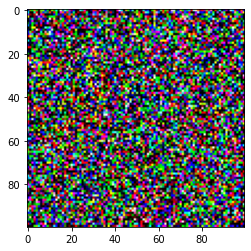

In [54]:
plt.imshow(gen_img[0].permute(1,2,0).detach())
plt.show()

In [55]:
def get_critic_scores(real_batch, batchSize, critic):
    #generator.batchSize = batchSize
    critic.batchSize = batchSize
    #generate fake images
    #randoBatch = torch.rand([batchSize, 100, 1, 1])
    #generated = generator(randoBatch)
    generated = gen_img
    #compute scores of both real and fake using the critic
    real_scores = critic(real_batch[0])
    gen_scores = critic(generated)
    return ( torch.sum(real_scores) , torch.sum(gen_scores) )

In [56]:
def get_generator_score(batchSize, critic):
    #generator.batchSize = batchSize
    #generate fake images
    #randoBatch = torch.rand([batchSize, 100, 1, 1])
    #generated = generator(randoBatch)
    generated = gen_img
    #compute scores of generated using critic
    gen_scores = critic(generated)
    return gen_scores#torch.sum(gen_scores)

In [57]:
class WeightClipper(object):

    def __init__(self, frequency=5):
        self.frequency = frequency

    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = w.clamp(-0.01,0.01)
            module.weight.data = w

In [58]:
critic = Critic()
generator = Generator()
clipper = WeightClipper()
critic.apply(clipper)

Critic(
  (convBlocks): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fcBlocks): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10368, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Linear(in_

In [59]:
num_epochs = 100
critic_epochs = 10
gen_epochs = 1

In [60]:
criticOptim = optim.Adam(critic.parameters(), lr=0.0001)#, momentum=0)
genOptim = optim.RMSprop([gen_img], lr=0.05, momentum=0)

In [ ]:
for epoch in range(num_epochs):
    print('Entering epoch yay: ' + str(epoch))
    realScore = 0.0 
    fakeScore = 0.0
    mainLoss = 0.0
    #critic training loop
    for batch_no, batch in enumerate(dogloader):
        print('Critic batch: ' + str(batch_no))
        scores = get_critic_scores(batch, batchSize, critic)
        real_score = scores[0]
        gen_score = scores[1]
        #loss function
        loss = -( real_score - gen_score ) #+ 0.01 * ( torch.pow(real_score,2) + torch.pow(gen_score,2) ) #penalize for distance away from 0
        #some tracking of numbers here
        realScore += real_score.item()
        fakeScore += gen_score.item()
        mainLoss += loss.item()
        #optimize
        criticOptim.zero_grad()
        loss.backward()
        criticOptim.step()
        
        if (batch_no % critic_epochs == critic_epochs-1):
            break
    print(realScore)
    print(fakeScore)
    print(mainLoss)
    
    mainLoss = 0.0
    #generator training loop
    for gepoch in range(gen_epochs):
        print('Generator batch: ' + str(gepoch))
        gen_score = get_generator_score(batchSize, critic)
        #loss function
        loss = -gen_score
        #tracking of numbers
        mainLoss += loss.item()
        #optimize
        genOptim.zero_grad()
        loss.backward()
        genOptim.step()
    print(mainLoss)

Entering epoch yay: 0
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
Critic batch: 4
Critic batch: 5
Critic batch: 6
Critic batch: 7
Critic batch: 8
Critic batch: 9
-0.14806134533137083
-0.164553745649755
-0.01649240031838417
Generator batch: 0
0.022660955786705017
Entering epoch yay: 1
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
Critic batch: 4
Critic batch: 5
Critic batch: 6
Critic batch: 7
Critic batch: 8
Critic batch: 9
-0.14218204282224178
-0.37419325672090054
-0.2320112120360136
Generator batch: 0
0.07905343919992447
Entering epoch yay: 2
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
Critic batch: 4
Critic batch: 5
Critic batch: 6
Critic batch: 7
Critic batch: 8
Critic batch: 9
-0.08514179848134518
-1.447294320911169
-1.3621525093913078
Generator batch: 0
0.3408132791519165
Entering epoch yay: 3
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
Critic batch: 4
Critic batch: 5
Critic batch: 6
Critic batch: 7
Crit

In [ ]:
plt.imshow(dogdata[0][0].permute(1,2,0))
plt.show()

critic.batchSize = 1
critic.eval()
print(critic(dogdata[800][0].unsqueeze(0)))
rando = torch.rand([1, 100, 1, 1])
print(critic(gen_img))

gen = generator(rando)
plt.imshow(gen_img[0].permute(1,2,0).detach().numpy())
plt.show()